In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import squarify
%matplotlib inline

from urllib.parse import urlencode
import requests

## Задания

1. Сколько студентов успешно сдали только один курс? Успешная сдача — это зачёт по курсу на экзамене. Оценка ниже 40 неудачная/неуспешная сдача теста.

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью (*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен).

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). 

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

  - В адаптированной кластеризации можешь выбрать следующие метрики: 

    - R - среднее время сдачи одного экзамена, 
    - F - завершаемость курсов, 
    - M - среднее количество баллов, получаемое за экзамен.

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

## Разведывательный анализ данных

Убедимся, что данные считываются

In [2]:
# Используем API
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url_assessments = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
url_courses = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
url_student_assessment = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
url_student_registration = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'

# Получаем URL
visits_url_assessments = base_url + urlencode(dict(public_key = url_assessments))
visits_url_courses = base_url + urlencode(dict(public_key = url_courses))
visits_url_student_assessment = base_url + urlencode(dict(public_key = url_student_assessment))
visits_url_student_registration = base_url + urlencode(dict(public_key = url_student_registration))
    
response_1 = requests.get(visits_url_assessments) 
download_url_1 = response_1.json()['href'] 
    
response_2 = requests.get(visits_url_courses) 
download_url_2 = response_2.json()['href'] 

response_3 = requests.get(visits_url_student_assessment) 
download_url_3 = response_3.json()['href'] 
    
response_4 = requests.get(visits_url_student_registration) 
download_url_4 = response_4.json()['href'] 
         
# Загружаем файл в df 
download_response_1 = requests.get(download_url_1)
download_response_2 = requests.get(download_url_2)
download_response_3 = requests.get(download_url_3)
download_response_4 = requests.get(download_url_4)
    
assessments = pd.read_csv(download_url_1)
courses = pd.read_csv(download_url_2)
student_assessment = pd.read_csv(download_url_3)
student_registration = pd.read_csv(download_url_4)

In [3]:
assessments.head(2)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0


In [4]:
courses.head(2)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269


Файл содержит информацию по курсам, семестрам и продолжительности каждого курса.

`code_module` — предмет (идентификационный код).

`code_presentation` — семестр (идентификационный код).

`module_presentation_length` — продолжительность семестра в днях.

In [5]:
student_assessment.head(2)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0


Файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

`id_assessment` — тест (идентификационный номер).

`id_student` — идентификационный номер студента.

`date_submitted` — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

`is_banked` — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

`score` — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [6]:
student_registration.head(2)

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN


Файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

`code_module` — предмет (идентификационный код).

`code_presentation` — семестр (идентификационный код)

`id_student` — идентификационный номер студента.

`date_registration` — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

`date_unregistration` — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

Данные считались корректно, перейдем к самому анализу данных.

Далее проверим:
 - размеры таблиц;
 - типы данных;
 - наличие пропусков;
 - наличие дублей.

In [7]:
print(f'В таблице assessments {assessments.shape[0]} строк и {assessments.shape[1]} колонок\n')
print(f'В таблице courses {courses.shape[0]} строк и {courses.shape[1]} колонок\n')
print(f'В таблице student_assessment {student_assessment.shape[0]} строк и {student_assessment.shape[1]} колонок\n')
print(f'В таблице student_registration {student_registration.shape[0]} строк и {student_registration.shape[1]} колонок')

В таблице assessments 206 строк и 6 колонок

В таблице courses 22 строк и 3 колонок

В таблице student_assessment 173912 строк и 5 колонок

В таблице student_registration 32593 строк и 5 колонок


In [8]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

In [9]:
courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

In [10]:
student_assessment.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

In [11]:
student_registration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

Проверим количество уникальных значений

In [12]:
print(f'В таблице assessments {assessments[assessments.duplicated ()].shape[0]} дублирующихся значений по полной строке\n')
print(f'В таблице courses {courses[courses.duplicated()].shape[0]} дублирующихся значений по полной строке\n')
print(f'В таблице student_assessment {student_assessment[student_assessment.duplicated()].shape[0]} дублирующихся значений по полной строке\n')
print(f'В таблице student_registration {student_assessment[student_assessment.duplicated()].shape[0]} дублирующихся значений по полной строке\n')
print(f'В таблице student_registration {student_registration[student_registration.id_student.duplicated()].shape[0]} дублирующихся значений по id студента')

В таблице assessments 0 дублирующихся значений по полной строке

В таблице courses 0 дублирующихся значений по полной строке

В таблице student_assessment 0 дублирующихся значений по полной строке

В таблице student_registration 0 дублирующихся значений по полной строке

В таблице student_registration 3808 дублирующихся значений по id студента


По всем строкам нет дублей во всех таблицах, однако в таблице **`student_registration`** есть 3808 повторяющихся значений (id студентов), что говорит о том, что кто-то регистрировался на курс не 1 раз. В дальнейших расчетах это нужно учесть.

Далее посмотрим, какие именно уникальные значения в таблице **`assessments`** в колонках `code_module`, `code_presentation`, `assessment_type` для того, чтобы определить понятие "***Курс***".

In [13]:
assessments.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64

In [14]:
assessments.code_module.unique()

array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

In [15]:
assessments.code_presentation.unique()

array(['2013J', '2014J', '2013B', '2014B'], dtype=object)

In [16]:
assessments.assessment_type.unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

In [17]:
courses.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

In [18]:
if assessments.code_module.unique().all() == courses.code_module.unique().all():
    print('Модули в таблицах идентичны')
else:
    print ('Модули в таблицах не совпадают')

Модули в таблицах идентичны


In [19]:
if assessments.code_presentation.unique().all() == courses.code_presentation.unique().all():
    print('Семестры в таблицах идентичны')
else:
    print ('Семестры в таблицах не совпадают')

Семестры в таблицах идентичны


Как мы видим из таблиц **`assessments`** и **`courses`**, у нас 7 уникальных модулей (назовем их **"курсами"** по определенному предмету) и 4 семестра (данные в таблицах совпадают). Также присутствует 3 типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

In [20]:
student_assessment.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

In [21]:
student_registration.nunique()

code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64

Из таблиц **`student_assessment`** и **`student_registration`** можно увидеть, что количество уникальных id студентов различается, что говорит о том, что не все зарегистрировашиеся студенты прошли тестирование.

In [22]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [23]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [24]:
student_assessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [25]:
student_registration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

В некоторых таблицах присутствуют NaN значения, например, в таблице **`assessments`** 11 пропущенных значений в колонке `date`- это информация об окончательной дате сдачи теста (количество дней с момента начала семестра). Здесь мы можем сделать допущение, что для данных модулей это значение может равняться продолжительности семестра в днях - `module_presentation_length` из таблицы **`courses`**.

В таблице **`student_assessment`** - 173 пропущенных значений - оценок за тест, возможно это ошибка при записи данных. А также в таблице **`student_registration`** 45 пропущенных дат регистрации (`date_registration`), однако у некоторых таких строк есть даты отмены регистрации - `date_unregistration` (таблица представлена ниже), что странно и возможно является ошибкой записи данных.

In [26]:
student_registration[student_registration.date_registration.isna()==True].head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0


## Предобработка данных

Отфильтруем только те тесты, которые имеют тип оценивания "Экзамен" (Exam) для дальнейшего ответа на первый вопрос - сколько студентов успешно сдали только один курс, если успешная сдача — это *зачёт* по *курсу* на экзамене. 

По условию:
***Зачёт*** - студент получил 40 баллов и выше. 
***Курс*** - это `code_module`.

In [27]:
only_exams_df = assessments.query('assessment_type == "Exam"')
only_exams_df.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

Создадим список тестов (`id_assessment`), относящихся к экзаменам

In [28]:
only_exams_list = only_exams_df.id_assessment.tolist()

Объединим таблицы **`assessments`** и **`courses`**

In [29]:
courses_assessments = assessments.merge(courses, how = 'inner', on = ['code_module','code_presentation'])

In [30]:
courses_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
0,AAA,2013J,1752,TMA,19.0,10.0,268
1,AAA,2013J,1753,TMA,54.0,20.0,268
2,AAA,2013J,1754,TMA,117.0,20.0,268
3,AAA,2013J,1755,TMA,166.0,20.0,268
4,AAA,2013J,1756,TMA,215.0,30.0,268


Заполним пропуски колонки `date` - окончательной даты сдачи теста на продолжительность семестра, исходя из допущения, сделанного выше. Проверим, что все получилось.

In [31]:
courses_assessments['date'] = courses_assessments['date'].fillna(courses_assessments['module_presentation_length'])

In [32]:
courses_assessments.isna().sum()

code_module                   0
code_presentation             0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
module_presentation_length    0
dtype: int64

Пропусков больше нет.

Объединим таблицы `student_assessment` и `courses_assessments`

In [33]:
student_assessment_courses = student_assessment.merge(courses_assessments, how = 'inner', on = 'id_assessment')
student_assessment_courses.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,268
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,268
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,268
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,268


Проверим количество уникальных записей в каждой колонке

In [34]:
student_assessment_courses.nunique()

id_assessment                   188
id_student                    23369
date_submitted                  312
is_banked                         2
score                           101
code_module                       7
code_presentation                 4
assessment_type                   3
date                             74
weight                           24
module_presentation_length        7
dtype: int64

Отфильтруем только тех студентов, которым не перезачли тесты с прошлого семестра.

In [35]:
student_assessment_courses_no_banked = student_assessment_courses.query('is_banked == 0')
student_assessment_courses_no_banked.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,268
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,268
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,268
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,268


In [36]:
#st_gr_a = student_assessment.groupby(['id_assessment','id_student'],as_index=False).agg({'score':'mean'})
#st_gr_a

In [37]:
#st_gr_a[st_gr_a.duplicated (['id_student'])]

Введем дополнительное условие, сдача до "***дедлайна***". В условии про это ничего не говорится, но чаще всего в курсах, как в университете, так и в онлайн курсах - это важно! 

Добавим новую колонку `delta_date` в таблицу `student_assessment_courses` - разница между днем сдачей тестов и "***дедлайном***", если число положительное или 0 - сдал в срок, отрицательное - после "***дедлайна***". 

Дополним также понятие ***Зачёт*** по курсу, в дополнении к оценке, зачет получает студент, который сдал курс до "***дедлайна***", то есть `delta_date` больше или равно 0.

In [38]:
student_assessment_courses['delta_date'] = student_assessment_courses['date'] - student_assessment_courses['date_submitted']
student_assessment_courses.head(2)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,delta_date
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268,1.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,268,-3.0


In [39]:
student_assessment_courses.isna().sum()

id_assessment                   0
id_student                      0
date_submitted                  0
is_banked                       0
score                         173
code_module                     0
code_presentation               0
assessment_type                 0
date                            0
weight                          0
module_presentation_length      0
delta_date                      0
dtype: int64

## Визуализация данных

Ответим на вопрос, какое количество тестов в зависимости от типа оценивания (TMA, CMA, Exam) в каждом курсе и в каждом семестре.

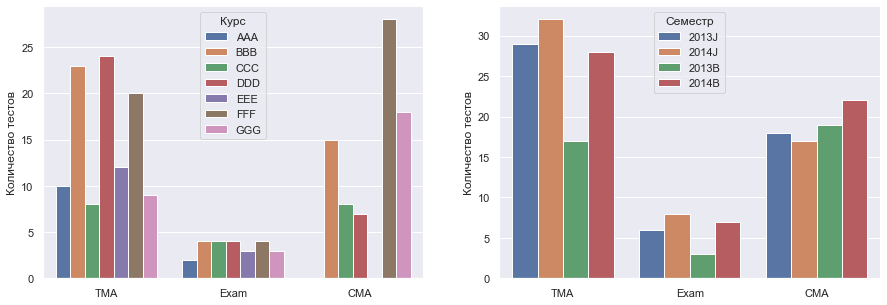

In [40]:
sns.set(rc={'figure.figsize':(15,5)})
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1 = sns.countplot(data = assessments, x = "assessment_type", hue = 'code_module', ax = ax1)
ax1.set (xlabel='', ylabel='Количество тестов')
ax1.legend(title='Курс') 

ax2 = sns.countplot(data = assessments, x = "assessment_type", hue = 'code_presentation', ax = ax2)
ax2.set (xlabel='', ylabel='Количество тестов')
ax2.legend(loc='upper center', title='Семестр')

sns.despine()  # убрать часть рамки графика
plt.show()

Видно из графиков, что меньше всего тестов приходится на тип оценивания Exam в каждом курсе и в каждом семестре.

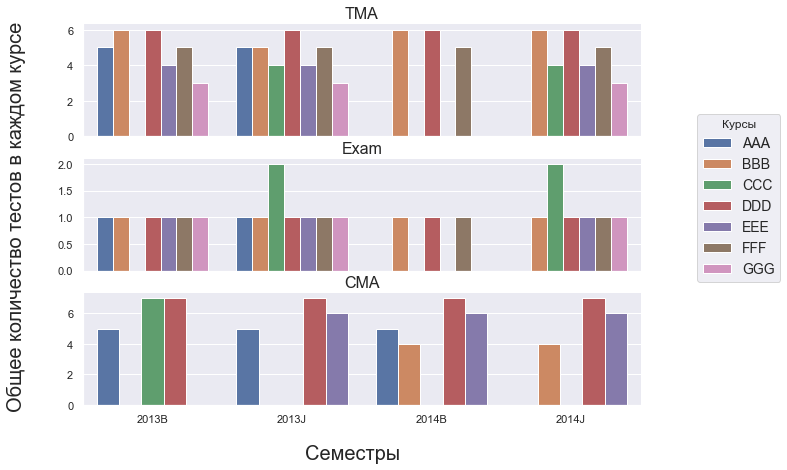

In [41]:
sns.set(rc={'figure.figsize':(10,7)})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1 = sns.countplot(data = assessments[assessments.assessment_type == "TMA"], x = "code_presentation", hue = 'code_module',ax = ax1)
ax1.set (xlabel='', ylabel='')
ax1.legend(bbox_to_anchor=(1.25, 0.2), borderaxespad= 0, fontsize=14, title='Курсы')
ax1.get_xaxis().set_visible(False)  # убрать значения оси х
ax1.set_title('TMA',fontsize=16)

ax2 = sns.countplot(data = assessments[assessments.assessment_type == "Exam"], x = "code_presentation", hue = 'code_module',ax = ax2)
ax2.set (xlabel='', ylabel='')
ax2.legend().set_visible(False) # убрать легенду
ax2.get_xaxis().set_visible(False)
ax2.set_title('Exam',fontsize=16)

ax3 = sns.countplot(data = assessments[assessments.assessment_type == "CMA"], x = "code_presentation", hue = 'code_module',ax = ax3)
ax3.set (xlabel='', ylabel='')
ax3.legend().set_visible(False)
ax3.set_title('CMA',fontsize=16)

fig.supylabel('Общее количество тестов в каждом курсе',fontsize=20)
fig.supxlabel('Семестры',fontsize=20)

sns.despine()  # убрать часть рамки графика
plt.show()

Из графиков видно, что у некоторых курсов не предусмотрены тесты с различным типом оценивания.
Кроме того, в каждом семестре количество тестов в каждом курсе может отличаться и даже полностью отсутствовать.

Для наглядного представления данных, посмотрим, как распределены оценки за экзамены по двум предметам CCC и DDD.

In [74]:
students_pass_exam_df = student_assessment_courses.query('assessment_type == "Exam" and score>=40 and delta_date>=0')

Посмотрим, как распределены оценки положительные оценки (>40) за экзамены по двум предметам CCC и DDD.

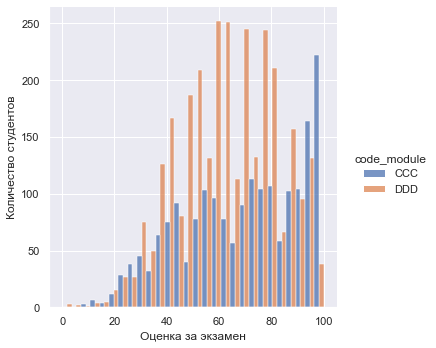

In [75]:
ax = sns.displot(data = exam_students, x= 'score',hue='code_module',  multiple='dodge')
ax.set (xlabel='Оценка за экзамен', ylabel='Количество студентов')

sns.despine()  # убрать часть рамки графика
plt.show()

Исходя из графика, меньше студентов сдавали курс ССС, по сравнению с DDD. 

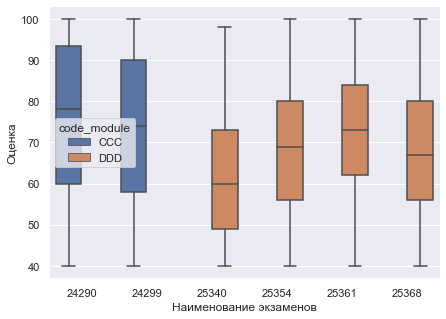

In [76]:
sns.set(rc={'figure.figsize':(7,5)})
ax = sns.boxplot(x = 'id_assessment', y = 'score', data = students_pass_exam_df, hue = 'code_module')
ax.set (xlabel='Наименование экзаменов', ylabel='Оценка')
sns.despine()  # убрать часть рамки графика
plt.show()

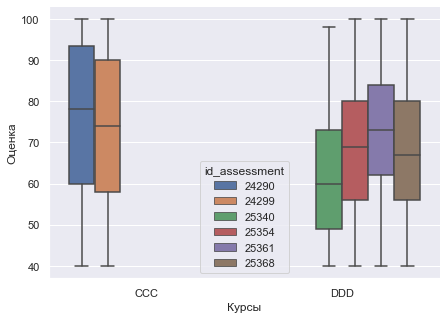

In [77]:
ax = sns.boxplot(x = 'code_module', y = 'score', data = students_pass_exam_df, hue = 'id_assessment')
ax.set (xlabel='Курсы', ylabel='Оценка')
sns.despine()  # убрать часть рамки графика
plt.show()

Здесь показаны медианы и границы доверительных интервалов положительных оценок среди студентов, с разбивкой по предметам.

Самый сложный экзамен - **25340**, исходя из полученного графика (медиана самая меньшая).

## Ответы на вопросы

**Вопрос 1**

Сколько студентов успешно сдали только один курс? Успешная сдача — это зачёт по курсу на экзамене. Оценка ниже 40 неудачная/неуспешная сдача теста. ***Курс*** - `code_module`.

Отфильтруем студентов, которые успешно сдали экзамен (оценка по экзамену > 40, и дополнительный критерий - сдали в срок, до "***дедлайна***").

In [78]:
students_pass_exam_df.groupby('id_student',as_index = False)\
                     .agg({'code_module':'count'})\
                     .rename(columns={'code_module':'count_module'})\
                     .groupby('count_module',as_index = False)\
                     .agg({'id_student':'count'})\
                     .rename(columns={'id_student':'count_student'})

,count_module,count_student
0,1,3792
1,2,295


Рассчитаем то же самое, но без учета "***дедлайнов***"

In [79]:
student_assessment_courses.query('assessment_type == "Exam" and score>=40').groupby('id_student',as_index = False)\
                     .agg({'code_module':'count'})\
                     .rename(columns={'code_module':'count_module'})\
                     .groupby('count_module',as_index = False)\
                     .agg({'id_student':'count'})\
                     .rename(columns={'id_student':'count_student'})

,count_module,count_student
0,1,3802
1,2,295


**Ответ на 1 вопрос:** **3792** студента успешно сдали только 1 курс, если мы будем учитывать сдачу теста в срок, или **3802** студента без учета "дедлайна".

**Дополнительный вопрос**

Посчитать количество студентов, кому перезачли предметы с прошлого семестра.

In [80]:
student_assessment_courses.query('is_banked == 1').assessment_type.unique()

array(['TMA', 'CMA'], dtype=object)

Студентам перезачли предметы только с типом оценивания TMA и CMA, не экзамены, поэтому при ответе на вопрос мы не будем их учитывать. 

In [81]:
st = len(pd.unique(student_assessment_courses.query('is_banked == 1').id_assessment))
print ('Количество cтудентов, кому перезачли тесты (только типа TMA и CMA) с прошлых семестров, составляет', st, 'человек')

Количество cтудентов, кому перезачли тесты (только типа TMA и CMA) с прошлых семестров, составляет 120 человек


**Вопрос 2**

Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью (***завершаемость*** = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен).

Отфильтруем датасет, в котором будут студенты, которые сдавали экзамен.

In [82]:
exam_students = student_assessment_courses.query('assessment_type == "Exam"')
exam_students.head(3)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,delta_date,actual_score
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,241.0,100.0,241,11.0,32.0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,241.0,100.0,241,7.0,78.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,241.0,100.0,241,11.0,54.0


Создадим два датасета, в первом посчитаем количество всех студентов, которые сдавали экзамены в рамках курса и модуля, во втором - посчитаем, сколько студентов успешно сдали экзамены аналогично в рамках курса и модуля. Объединим датасеты, посчитаем конверсию (`Completion rate` – показатель ***завершаемости курсов*** или ***доходимости***), и выявим самый сложный курс.

In [83]:
all_exam = exam_students.groupby(['code_module','id_assessment'],as_index=False)\
                        .agg({'id_student':'nunique'}).rename(columns={'id_student':'all_students'})
all_exam

,code_module,id_assessment,all_students
0,CCC,24290,747
1,CCC,24299,1168
2,DDD,25340,602
3,DDD,25354,968
4,DDD,25361,524
5,DDD,25368,950


Далее будем считать, что все-таки успешная сдача - это сдача в срок, до ***дедлайна***.

In [84]:
success_exam = students_pass_exam_df.groupby(['code_module','id_assessment'],as_index=False)\
                                    .agg({'id_student':'nunique'}).rename(columns={'id_student':'success_students'})
success_exam

,code_module,id_assessment,success_students
0,CCC,24290,662
1,CCC,24299,1018
2,DDD,25340,501
3,DDD,25354,878
4,DDD,25361,482
5,DDD,25368,841


In [85]:
exam_merge_completion_rate = success_exam.merge(all_exam, how = 'inner', on = ['code_module','id_assessment'])
exam_merge_completion_rate

,code_module,id_assessment,success_students,all_students
0,CCC,24290,662,747
1,CCC,24299,1018,1168
2,DDD,25340,501,602
3,DDD,25354,878,968
4,DDD,25361,482,524
5,DDD,25368,841,950


In [86]:
exam_merge_completion_rate['completion_rate'] = round(exam_merge_completion_rate['success_students']/exam_merge_completion_rate['all_students']*100)
exam_merge_completion_rate.sort_values('completion_rate')

,code_module,id_assessment,success_students,all_students,completion_rate
2,DDD,25340,501,602,83.0
1,CCC,24299,1018,1168,87.0
0,CCC,24290,662,747,89.0
5,DDD,25368,841,950,89.0
3,DDD,25354,878,968,91.0
4,DDD,25361,482,524,92.0


**Ответ на 2 вопрос:** Самый сложный экзамен - **25340**, в рамках курса **DDD**, который обладает самой низкой завершаемостью. Самый простой экзамен - **25361**, также в рамках курса **DDD**, который обладает самой высокой завершаемостью.

**Дополнительные вопросы**

    1) Сколько студентов успешно завершили 1 с учетом так называемого допуска?
    2) Выяви самый сложный и самый простой экзамен с учетом допуска?

Из данных задачи неясно, нужно ли студентам получать допуск, прежде чем сдавать экзамен. Под ***допуском*** будем понимать сумму баллов по остальным тестам (кроме экзамена) с учетом их веса `weight` (доля в %) в общей оценке, превышающую 40 баллов.

Расчитаем реальный балл - `actual_score`- по тестам (они же ассесменты), кроме экзаменов, с учетом веса каждого. Для этого умножим полученный балл `score` на `weight` и разделим на 100.

In [87]:
student_assessment_courses['actual_score'] = student_assessment_courses.score*student_assessment_courses.weight/100
student_assessment_courses.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,delta_date,actual_score
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268,1.0,7.8
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,268,-3.0,7.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,268,2.0,7.2
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,268,-7.0,6.9
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,268,0.0,7.9


In [88]:
students_can_pass_exam = student_assessment_courses.query('assessment_type != "Exam" and delta_date>=0')\
                          .groupby(['id_student','code_presentation','code_module'],as_index=False)\
                          .agg({'actual_score':'sum'})\
                          .query('actual_score >= 40')
students_can_pass_exam_list = students_can_pass_exam.id_student.tolist() # Список студентов, получивших допуск

In [89]:
students_pass_exam_df_1 = students_pass_exam_df[students_pass_exam_df['id_student'].isin(students_can_pass_exam_list)]
students_pass_exam_df_1.head(3)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,delta_date,actual_score
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,241.0,100.0,241,7.0,78.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,241.0,100.0,241,11.0,54.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,241.0,100.0,241,11.0,64.0


In [90]:
students_pass_exam_df_1.groupby('id_student',as_index = False)\
                     .agg({'code_module':'count'})\
                     .rename(columns={'code_module':'count_module'})\
                     .groupby('count_module',as_index = False)\
                     .agg({'id_student':'nunique'})\
                     .rename(columns={'id_student':'count_student'})

,count_module,count_student
0,1,2847
1,2,260


In [91]:
success_exam_1 = students_pass_exam_df_1.groupby(['code_module','id_assessment'],as_index=False)\
                                    .agg({'date_submitted':'count'}).rename(columns={'date_submitted':'count_students_exam'})\
                                    .sort_values('count_students_exam')
success_exam_1

,code_module,id_assessment,count_students_exam
2,DDD,25340,351
4,DDD,25361,391
0,CCC,24290,441
1,CCC,24299,713
5,DDD,25368,727
3,DDD,25354,744


Объединим датасеты со студентами, которые сдавали экзамены и которые успешно сдали (но сначала получив допуск) в рамках предмета 

In [92]:
exam_merge_completion_rate_1 = success_exam_1.merge(all_exam, how = 'inner', 
                                                    on = ['code_module','id_assessment']).sort_values('all_students')
exam_merge_completion_rate_1

,code_module,id_assessment,count_students_exam,all_students
1,DDD,25361,391,524
0,DDD,25340,351,602
2,CCC,24290,441,747
4,DDD,25368,727,950
5,DDD,25354,744,968
3,CCC,24299,713,1168


In [93]:
exam_merge_completion_rate_1['completion_rate'] = round(exam_merge_completion_rate_1['count_students_exam']/exam_merge_completion_rate_1['all_students']*100)
exam_merge_completion_rate_1.sort_values('completion_rate')

,code_module,id_assessment,count_students_exam,all_students,completion_rate
0,DDD,25340,351,602,58.0
2,CCC,24290,441,747,59.0
3,CCC,24299,713,1168,61.0
1,DDD,25361,391,524,75.0
4,DDD,25368,727,950,77.0
5,DDD,25354,744,968,77.0


**Ответы на дополнительные вопросы:** 

    1) 2847 студентов сдали успешно 1 курс с учетом допуска. 
    2) 25340 - самый сложный предмет (экзамен), 25354 - самый простой, с учетом полученных допусков.

**Вопрос 3**

По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

Сгруппируем данные по `code_module`, то есть курсу, посчитаем средние сроки сдачи `date_submitted`.

In [94]:
students_pass_exam_df.groupby(['code_module'],as_index=False)\
                          .agg({'date_submitted':'mean'}).rename(columns={'date_submitted':'mean_days'}).round()

,code_module,mean_days
0,CCC,239.0
1,DDD,238.0


**Ответ на 3 вопрос:** Средний срок сдачи студентами экзаменов по предметам: **CCC** и **DDD** - **239 дней** и **238 дней** соответственно.

**Вопрос 4**

Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

Для начала определим понятие ***отток***. Существует такая маркетинговая метрика - `churn_rate` - отток пользователей, и она считается, как отношение количества потерянных покупателей в конце периода к общему их числу в начале периода. Результат умножается на 100%.

Но для начала еще раз повнимательнее посмотрим на таблицу **`student_registration`**. Проанализируем, сколько раз студенты в принципе регистрировались на курс и отменяли регистрацию.

In [95]:
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


Количество студентов, которые записывались на курс несколько раз (от 0 до 4) записываем в таблицу **`reg_df`**.

In [96]:
reg_df = student_registration.groupby(['code_module','id_student'],as_index=False)\
                    .agg({'date_registration':'count'})\
                    .groupby(['code_module','date_registration'],as_index=False)\
                    .agg({'id_student':'count'})\
                    .pivot(index='date_registration',columns='code_module',values='id_student')\
                    .fillna(0)
reg_df

code_module,AAA,BBB,CCC,DDD,EEE,FFF,GGG
date_registration,,,,,,,
0,0.0,9.0,7.0,8.0,1.0,10.0,0.0
1,676.0,7474.0,4062.0,5437.0,2785.0,7037.0,2516.0
2,36.0,202.0,182.0,390.0,72.0,336.0,9.0
3,0.0,6.0,0.0,12.0,1.0,14.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Количество студентов, которые отменяли регистрацию на курс несколько раз (от 0 до 4) записываем в таблицу **`unreg_df`**.

In [97]:
unreg_df = student_registration.groupby(['code_module','id_student'],as_index=False)\
                    .agg({'date_unregistration':'count'})\
                    .groupby(['code_module','date_unregistration'],as_index=False)\
                    .agg({'id_student':'count'})\
                    .pivot(index='date_unregistration',columns='code_module',values='id_student')\
                    .fillna(0)
unreg_df

code_module,AAA,BBB,CCC,DDD,EEE,FFF,GGG
date_unregistration,,,,,,,
0,596.0,5378.0,2393.0,3783.0,2166.0,5148.0,2238.0
1,106.0,2255.0,1769.0,1905.0,668.0,2124.0,285.0
2,10.0,56.0,89.0,151.0,25.0,119.0,2.0
3,0.0,2.0,0.0,8.0,0.0,6.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Получается, что студенты на один и тот же курс могли регистрироваться и отменять регистрацию по несколько раз. Встречаются случаи, когда студенты вовсе не регистрировались на курс, это странно, так как запись о них в таблице присутствует, возможно это ошибка записи. Получается большее количество студентов регистрировалось 1 раз, однако встречаются случаи, когда они регистрировались 2,3,4 раза - это гораздо меньшее число людей.

Чтобы ответить на вопрос, далее создадим 2 таблицы с количеством студентов, зарегистрировавшихся на курс **`module_reg`**, и отменивших регистрацию **`module_unreg`**, в разбивке по курсу `code_module`, и объединим их.

In [98]:
module_reg = student_registration[student_registration.date_registration.isna() == False]\
                    .groupby('code_module',as_index=False)\
                    .agg({'id_student':'nunique'})\
                    .sort_values('id_student',ascending = False)\
                    .rename(columns={'id_student':'reg_students'})
module_reg.head(3)

,code_module,reg_students
1,BBB,7683
5,FFF,7387
3,DDD,5840


In [99]:
module_unreg = student_registration[student_registration.date_unregistration.isna() == False].\
                    groupby('code_module',as_index=False)\
                    .agg({'id_student':'nunique'})\
                    .sort_values('id_student',ascending = False)\
                    .rename(columns={'id_student':'unreg_students'})
module_unreg

,code_module,unreg_students
1,BBB,2314
5,FFF,2249
3,DDD,2065
2,CCC,1858
4,EEE,693
6,GGG,287
0,AAA,116


Посчитаем отток, и выберем ТОП-3 предмета (то есть курса), с самым высоким оттоком.

In [100]:
all_reg = module_reg.merge(module_unreg, how = 'inner', on = 'code_module')
all_reg['churn_rate'] = round(all_reg.unreg_students/all_reg.reg_students*100)
all_reg.sort_values('churn_rate',ascending = False).head(3)

,code_module,reg_students,unreg_students,churn_rate
3,CCC,4244,1858,44.0
2,DDD,5840,2065,35.0
0,BBB,7683,2314,30.0


**Ответ на 4 вопрос:** Самые популярные предметы - BBB, FFF, DDD (определили по количеству регистраций). Предметы с самым большим оттоком (`churn_rate`) - CCC, DDD, BBB.

**Вопрос 5**

Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

***Завершаемость*** = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен.

Посчитаем завершаемость - `completion_rate` - с разбивкой по семестрам `code_presentation`.

In [101]:
success_term = students_pass_exam_df.groupby(['code_presentation'],as_index=False)\
                                    .agg({'id_student':'nunique'}).rename(columns={'id_student':'success_students'})
success_term

,code_presentation,success_students
0,2013B,501
1,2013J,878
2,2014B,1135
3,2014J,1812


In [102]:
exam_students_new = exam_students.groupby('code_presentation',as_index = False)\
                     .agg({'date_submitted':'mean', 'id_student' :'nunique'}).round(2)\
                     .rename(columns={'date_submitted':'mean_days','id_student':'all_students'})\
                     .merge(success_term, how = 'inner', on = ['code_presentation'])
exam_students_new

,code_presentation,mean_days,all_students,success_students
0,2013B,230.18,602,501
1,2013J,239.51,968,878
2,2014B,232.99,1261,1135
3,2014J,243.67,2068,1812


In [103]:
exam_students_new['completion_rate'] = round(exam_students_new['success_students']/exam_students_new['all_students']*100)

In [104]:
exam_students_new[['code_presentation','mean_days','completion_rate']].sort_values('mean_days')

,code_presentation,mean_days,completion_rate
0,2013B,230.18,83.0
2,2014B,232.99,90.0
1,2013J,239.51,91.0
3,2014J,243.67,88.0


**Ответ на 5 вопрос:** Семестр с самой низкой завершаемостью курсов (`completion_rate`) - **2013B**, семестр с самыми долгими средними сроками сдачи курсов - **2014J**.

**Вопрос 6**

Используя python, построить адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию.

В адаптированной кластеризации будут следующие метрики:

- R (recency) - среднее время сдачи одного экзамена,
- F (frequency) - завершаемость курсов,
- M (monetary) - среднее количество баллов, получаемое за экзамен.

Нам необходимо сегментировать всех студентов, которые проходили курсы, в зависимости от того, на сколько баллов они сдали экзамен (M - среднее количество баллов, получаемое за экзамен), как быстро был сдан экзамен (R - среднее время сдачи одного экзамена), с какой попытки студенты смогу сдать экзамен (завершаемость курсов студентами).

Объединим таблицы **`student_assessment_courses`** и **`student_registration`**.

In [105]:
student_assessment_courses_registration = student_assessment_courses.merge(student_registration, how = 'inner', 
                                                                           on = ['id_student','code_module','code_presentation'])
student_assessment_courses_registration.head(3)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,delta_date,actual_score,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268,1.0,7.8,-159.0,NaN
1,1753,11391,53,0,85.0,AAA,2013J,TMA,54.0,20.0,268,1.0,17.0,-159.0,NaN
2,1754,11391,115,0,80.0,AAA,2013J,TMA,117.0,20.0,268,2.0,16.0,-159.0,NaN


Отфильтруем тех студентов, у кого количество регистраций на курс превышает количество отмен регистрации и запишем таких студентов в список `id_student_list`.

In [106]:
id_student_list = student_assessment_courses_registration.groupby('id_student',as_index=False)\
                                       .agg({'date_registration':'count','date_unregistration':'count'})\
                                       .query('date_registration > date_unregistration').id_student.tolist()

In [107]:
students_df_for_rfm = student_assessment_courses_registration[student_assessment_courses_registration['id_student'].isin(id_student_list)]
students_df_for_rfm.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,delta_date,actual_score,date_registration,date_unregistration
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,268,1.0,7.8,-159.0,NaN
1,1753,11391,53,0,85.0,AAA,2013J,TMA,54.0,20.0,268,1.0,17.0,-159.0,NaN
2,1754,11391,115,0,80.0,AAA,2013J,TMA,117.0,20.0,268,2.0,16.0,-159.0,NaN
3,1755,11391,164,0,85.0,AAA,2013J,TMA,166.0,20.0,268,2.0,17.0,-159.0,NaN
4,1756,11391,212,0,82.0,AAA,2013J,TMA,215.0,30.0,268,3.0,24.6,-159.0,NaN


Расчитаем среднее время сдачи экзамена и средний балл.

In [108]:
rfm_df = students_df_for_rfm.query('assessment_type == "Exam"')\
                    .groupby(['id_student','code_module'])\
                    .agg({'date_submitted':'mean','score': 'mean'})\
                    .reset_index()\
                    .rename(columns = {'date_submitted':'mean_date','score':'mean_score'})
rfm_df.head()

,id_student,code_module,mean_date,mean_score
0,23698,CCC,243.0,80.0
1,24213,DDD,236.0,58.0
2,27116,CCC,243.0,96.0
3,28046,DDD,237.0,40.0
4,28787,CCC,243.0,44.0


In [109]:
# Подсчет количества экзаменов, которые сдавали студенты
count_allexams_df = student_assessment_courses_registration.query('assessment_type == "Exam"')\
                                        .groupby(['id_student'],as_index=False).agg({'date_submitted':'count'})\
                                        .rename(columns = {'date_submitted':'count_all_attempts'})
count_allexams_df.head()

,id_student,count_all_attempts
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1


In [141]:
# Подсчет количества экзаменов, которые студенты сдали успешно
count_success_df = student_assessment_courses_registration.query('assessment_type == "Exam" and score >=40 and delta_date>=0')\
                                        .groupby(['id_student'],as_index=False).agg({'date_submitted':'count'})\
                                        .rename(columns = {'date_submitted':'count_success_attempts'})
count_success_df.head()

,id_student,count_success_attempts
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1


In [142]:
rfm_df_1 = rfm_df.merge(count_allexams_df, how="inner", on = 'id_student')\
                    .merge(count_success_df, how="left", on = 'id_student')
rfm_df_1.head()

,id_student,code_module,mean_date,mean_score,count_all_attempts,count_success_attempts
0,23698,CCC,243.0,80.0,1,1.0
1,24213,DDD,236.0,58.0,1,1.0
2,27116,CCC,243.0,96.0,1,1.0
3,28046,DDD,237.0,40.0,1,1.0
4,28787,CCC,243.0,44.0,1,1.0


In [143]:
rfm_df_1['F_completion_rate'] = rfm_df_1.count_success_attempts/rfm_df_1.count_all_attempts*100
rfm_df_1.head()

,id_student,code_module,mean_date,mean_score,count_all_attempts,count_success_attempts,F_completion_rate
0,23698,CCC,243.0,80.0,1,1.0,100.0
1,24213,DDD,236.0,58.0,1,1.0,100.0
2,27116,CCC,243.0,96.0,1,1.0,100.0
3,28046,DDD,237.0,40.0,1,1.0,100.0
4,28787,CCC,243.0,44.0,1,1.0,100.0


Получим окончательный датафрейм с колонками R,F,M. 


In [154]:
rfm = rfm_df_1.rename(columns={'mean_date':'R_mean_date', 'mean_score':'M_mean_score'})[['id_student','R_mean_date','F_completion_rate','M_mean_score']]
rfm.head()

,id_student,R_mean_date,F_completion_rate,M_mean_score
0,23698,243.0,100.0,80.0
1,24213,236.0,100.0,58.0
2,27116,243.0,100.0,96.0
3,28046,237.0,100.0,40.0
4,28787,243.0,100.0,44.0


In [155]:
rfm.describe()

,id_student,R_mean_date,F_completion_rate,M_mean_score
count,4.954000e+03,4954.000000,4407.000000,4954.000000
mean,7.226703e+05,238.485668,99.364647,65.598002
std,5.680482e+05,5.717648,5.600990,20.568538
min,2.369800e+04,229.000000,50.000000,0.000000
25%,5.033902e+05,234.000000,100.000000,51.000000
50%,5.884875e+05,241.000000,100.000000,67.000000
75%,6.453052e+05,243.000000,100.000000,82.000000
max,2.698251e+06,285.000000,100.000000,100.000000


Быстрый статистический анализ показал, как варьируются значения R, F, M переменных. Из этого будет следовать, как мы будем сегментировать студентов.

Так как размах в данных не высок, будем разбивать студентов на 3 группы.

Кроме того, значения слишком разные, поэтому необходимо создавать все группы отдельно друг от друга. Мы видим, что в колонке `F_completion_rate` - в осномном все значения равняются 100%. Это значит, что почти все студенты сдали экзамен с 1 попытки.

In [156]:
quintile_r = rfm[['R_mean_date']].quantile([.1, .7]).to_dict()
quintile_f = rfm[['F_completion_rate']].quantile([.01, .5]).to_dict()
quintile_m = rfm[['M_mean_score']].quantile([.05, .12]).to_dict()

Обозначения:
    
**R_mean_date** - среднее время сдачи одного экзамена:

    1 - сдали быстрее всех
    2 - сдали в средний срок, вовремя
    3 - сдали позже всех
    
**F_completion_rate** - завершаемость курса
    
    1 – сдали экзамен с первой попытки
    2 – какие-то экзамены были сданы не с первой попытки
    3 – не сдали ни одного экзамена
    
**M_mean_score** - среднее количество баллов
    
    1 – лучшие баллы за экзамен
    2 – средние баллы за экзамен
    3 – не сдали экзамен (оценка ниже 40 баллов)

In [157]:
quintile_r

{'R_mean_date': {0.1: 230.0, 0.7: 243.0}}

In [158]:
quintile_f

{'F_completion_rate': {0.01: 50.0, 0.5: 100.0}}

In [159]:
quintile_m

{'M_mean_score': {0.05: 31.0, 0.12: 40.0}}

In [160]:
rfm['R'] = pd.cut(rfm.R_mean_date,
                         bins = [0, 230.0, 240.0, 365],
                         labels = ['1', '2', '3'])

rfm['F'] = pd.cut(rfm.F_completion_rate,
                         bins = [-1, 40, 50, 100],
                         labels = ['3', '2', '1'])

rfm['M'] = pd.cut(rfm.M_mean_score,
                         bins = [-1, 39, 76, 101],
                         labels = ['3', '2', '1'])

rfm.R = rfm.R.astype('object')
rfm.F = rfm.F.astype('object')
rfm.M = rfm.M.astype('object')

rfm['RM_Score'] = rfm['R'].map(str) + rfm['M'].map(str)
rfm.head(10)

,id_student,R_mean_date,F_completion_rate,M_mean_score,R,F,M,RM_Score
0,23698,243.0,100.0,80.0,3,1,1,31
1,24213,236.0,100.0,58.0,2,1,2,22
2,27116,243.0,100.0,96.0,3,1,1,31
3,28046,237.0,100.0,40.0,2,1,2,22
4,28787,243.0,100.0,44.0,3,1,2,32
5,29411,237.0,100.0,62.0,2,1,2,22
6,29420,244.0,100.0,62.0,3,1,2,32
7,29639,248.0,100.0,74.0,3,1,2,32
8,29764,230.0,100.0,94.0,1,1,1,11
9,29820,230.0,100.0,76.0,1,1,2,12


В дальнейшем сегментировании мы опустим параметр `F_completion_rate` - так как он у всех практически одинаковый, и не совсем адекватно будет вность вклад в RFM анализ. Будем ориентироваться на R и M критерии.

In [167]:
segt_map = {
    r'31': 'Отличники, сдающие не во время',
    r'32': 'Хорошисты, сдающие не во время',
    r'33': 'Совсем не старались, не сдали',
    
    r'21': 'Почти лучшие, отличники, сдали в середине',
    r'22': 'Сдали в средний срок, результат средний',
    r'23': 'Сдали в средний срок, но результаты плохие',
    
    r'11': 'Лучшие из лучших',
    r'12': 'Самые быстрые, но результат средний',
    r'13': 'Быстрые, но не сдали',

}

rfm['Segment'] = rfm['RM_Score'].replace(segt_map, regex=True)

In [168]:
rfm.Segment.value_counts()

Хорошисты, сдающие не во время                1428
Отличники, сдающие не во время                 908
Сдали в средний срок, результат средний        820
Самые быстрые, но результат средний            495
Почти лучшие, отличники, сдали в середине      452
Совсем не старались, не сдали                  308
Лучшие из лучших                               286
Сдали в средний срок, но результаты плохие     140
Быстрые, но не сдали                           117
Name: Segment, dtype: int64

In [169]:
rmf_group = rfm.groupby('Segment',as_index=False).agg({'id_student':'count'}).sort_values('id_student')
rmf_group

,Segment,id_student
0,"Быстрые, но не сдали",117
5,"Сдали в средний срок, но результаты плохие",140
1,Лучшие из лучших,286
7,"Совсем не старались, не сдали",308
3,"Почти лучшие, отличники, сдали в середине",452
4,"Самые быстрые, но результат средний",495
6,"Сдали в средний срок, результат средний",820
2,"Отличники, сдающие не во время",908
8,"Хорошисты, сдающие не во время",1428


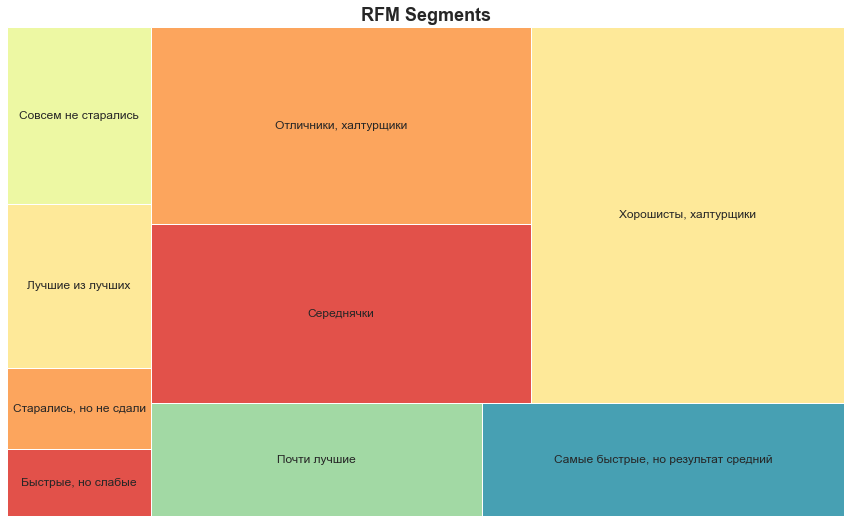

In [175]:
labels = ['Быстрые, но слабые',
          'Старались, но не сдали',
          'Лучшие из лучших', 
          'Совсем не старались',
          'Почти лучшие', 
          'Самые быстрые, но результат средний',
          'Середнячки',
          'Отличники, халтурщики',
          'Хорошисты, халтурщики']

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 9)
squarify.plot(sizes = rmf_group['id_student'], label = labels, color= sns.color_palette("Spectral"))
plt.title("RFM Segments",fontsize=18,fontweight="bold")

plt.axis("off")
plt.show()

In [176]:
rmf_group['percent'] = round(rmf_group.id_student/sum(rmf_group.id_student)*100)
rmf_group

,Segment,id_student,percent
0,"Быстрые, но не сдали",117,2.0
5,"Сдали в средний срок, но результаты плохие",140,3.0
1,Лучшие из лучших,286,6.0
7,"Совсем не старались, не сдали",308,6.0
3,"Почти лучшие, отличники, сдали в середине",452,9.0
4,"Самые быстрые, но результат средний",495,10.0
6,"Сдали в средний срок, результат средний",820,17.0
2,"Отличники, сдающие не во время",908,18.0
8,"Хорошисты, сдающие не во время",1428,29.0


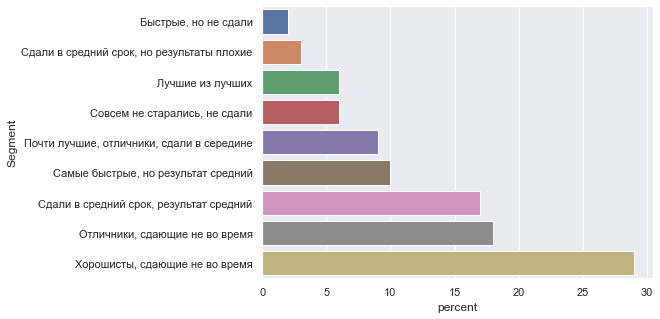

In [177]:
sns.barplot(x = 'percent', y = 'Segment', data = rmf_group)
plt.show()

**Ответ на 6 вопрос:** бОльшая часть студентов - 29% относится к категории: "Хорошисты, сдающие не во время".

Категория F - завершаемость курсов - не играет в данном случае особой роли, так как почти все студенты сдавали только 1 раз экзамен (фиксируется последняя попытка, а не все попытки), и в основном данные попытки были успешны. Поэтому, есть смысл не добавлять Кроме того, студенты сдавали 1 экзамен, в редких случаях 2, но данные экзамены сдавались в рамках разных курсов и разных семестров.